# **이진분류 실습: 이직 여부**

<center><img src = "https://github.com/Jangrae/img/blob/master/attrition.png?raw=true" width=800/></center>

## **1. 환경준비**

### (1) 라이브러리 불러오기

In [1]:
# 라이브러리 불러오기
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.backend import clear_session
from tensorflow.keras.optimizers import Adam
import warnings

warnings.filterwarnings(action='ignore')
%config InlineBackend.figure_format='retina'

### (2) 함수 만들기

In [2]:
# 함수 만들기
def dl_history_plot(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history['loss'], label='Train Loss', marker='.')
    plt.plot(history['val_loss'], label='Validation Loss', marker='.')

    plt.title('Learning Curve', size=15, pad=20)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

### (3) 데이터 준비

In [3]:
path = 'https://raw.githubusercontent.com/Jangrae/csv/master/Attrition_simple2.csv'
data = pd.read_csv(path)
data.head()

,Attrition,Age,DistanceFromHome,EmployeeNumber,Gender,JobSatisfaction,MaritalStatus,MonthlyIncome,OverTime,PercentSalaryHike,TotalWorkingYears
0,0,33,7,817,Male,3,Married,11691,No,11,14
1,0,35,18,1412,Male,4,Single,9362,No,11,10
2,0,42,6,1911,Male,1,Married,13348,No,13,18
3,0,46,2,1204,Female,1,Married,17048,No,23,28
4,1,22,4,593,Male,3,Single,3894,No,16,4


**데이터 설명**

- Attrition: 이직 여부 (1: 이직, 0: 잔류)
- Age: 나이
- DistanceFromHome: 집-직장 거리 (단위: 마일)
- EmployeeNumber: 사번
- Gender: 성별 (Male, Female)
- JobSatisfaction: 직무만족도(1: Low, 2: Medium, 3: High, 4: Very High)
- MaritalStatus: 결혼 상태 (Single, Married, Divorced)
- MonthlyIncome: 월급 (단위: 달러)
- OverTime: 야근 여부 (Yes, No)
- PercentSalaryHike: 전년 대비 급여 인상율(단위: %)
- TotalWorkingYears: 총 경력 연수

## **2. 모델링 1**

- 다양한 구조의 모델 2개 이상을 설계합니다.
- Hidden Layer, Node 수 조절

### (1) 데이터 전처리

#### 1) 데이터 준비

In [4]:
# 불필요한 변수 제거
data.drop(columns='EmployeeNumber', inplace=True)

In [5]:
# x, y 분리
target = 'Attrition'
x = data.drop(columns=target)
y = data.loc[:, target]

#### 2) 가변수화

- 범주형 데이터이면서 값이 0,1 로 되어 있는 것이 아니라면, 가변수화를 수행해야 합니다.
- 대상이 되는 변수에 대해서 가변수화를 수행합니다.

In [6]:
# 가변수화
dum_cols = ['Gender', 'MaritalStatus', 'OverTime']

x = pd.get_dummies(x, columns=dum_cols, drop_first=True, dtype=int)
x.head()

,Age,DistanceFromHome,JobSatisfaction,MonthlyIncome,PercentSalaryHike,TotalWorkingYears,Gender_Male,MaritalStatus_Married,MaritalStatus_Single,OverTime_Yes
0,33,7,3,11691,11,14,1,1,0,0
1,35,18,4,9362,11,10,1,0,1,0
2,42,6,1,13348,13,18,1,1,0,0
3,46,2,1,17048,23,28,0,1,0,0
4,22,4,3,3894,16,4,1,0,1,0


#### 3) 데이터 분할

In [7]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, stratify=y)

#### 4) 스케일링

In [8]:
cols = ['Age', 'DistanceFromHome', 'JobSatisfaction', 'MonthlyIncome', 'PercentSalaryHike', 'TotalWorkingYears']

scaler = MinMaxScaler()
x_train_scaled = x_train.copy()
x_train_scaled[cols] = scaler.fit_transform(x_train_scaled[cols])

x_val_scaled = x_val.copy()
x_val_scaled[cols] = scaler.transform(x_val_scaled[cols])


In [9]:
x_train_scaled.head()

,Age,DistanceFromHome,JobSatisfaction,MonthlyIncome,PercentSalaryHike,TotalWorkingYears,Gender_Male,MaritalStatus_Married,MaritalStatus_Single,OverTime_Yes
1176,0.095238,0.071429,1.000000,0.097391,0.000000,0.025,1,1,0,1
910,0.619048,0.964286,1.000000,0.650206,0.500000,0.575,0,1,0,1
801,0.476190,0.000000,1.000000,0.349424,0.142857,0.250,0,0,1,0
297,0.404762,0.250000,0.666667,0.175029,0.428571,0.150,1,0,1,0
167,0.404762,0.321429,0.000000,0.491021,0.428571,0.375,1,1,0,0


### (2) 모델링

#### 1) 모델 선언

In [10]:
clear_session()

nf = x_train_scaled.shape[1]

model1 = Sequential([
    Input(shape=(nf,)),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │           352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 897 (3.50 KB)

 Trainable params: 897 (3.50 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
model1.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy')

#### 2) 모델 학습

In [12]:
hist1= model1.fit(x_train_scaled, y_train, epochs=50, validation_split=0.2).history

Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.5762 - val_loss: 0.4880
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4666 - val_loss: 0.4242
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4321 - val_loss: 0.4060
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4118 - val_loss: 0.3951
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3975 - val_loss: 0.3870
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3859 - val_loss: 0.3811
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3775 - val_loss: 0.3770
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3725 - val_loss: 0.3755
Epoch 9/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3685 - val_loss: 0.3731
Epoch 10/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3650 - val_loss: 0.3724
Epoch 11/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3624 - val_loss: 0.3707
Epoch 12/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3601 - val_l

#### 3) 예측 및 성능 평가

In [13]:
y_pred1 = model1.predict(x_val_scaled)

y_pred1 = (0.5 < y_pred1).astype(int)
y_pred1[:5]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


array([[0],
       [0],
       [0],
       [0],
       [0]])

In [14]:
print(classification_report(y_val, y_pred1))

              precision    recall  f1-score   support

           0       0.85      0.94      0.89       198
           1       0.45      0.21      0.29        42

    accuracy                           0.82       240
   macro avg       0.65      0.58      0.59       240
weighted avg       0.78      0.82      0.79       240



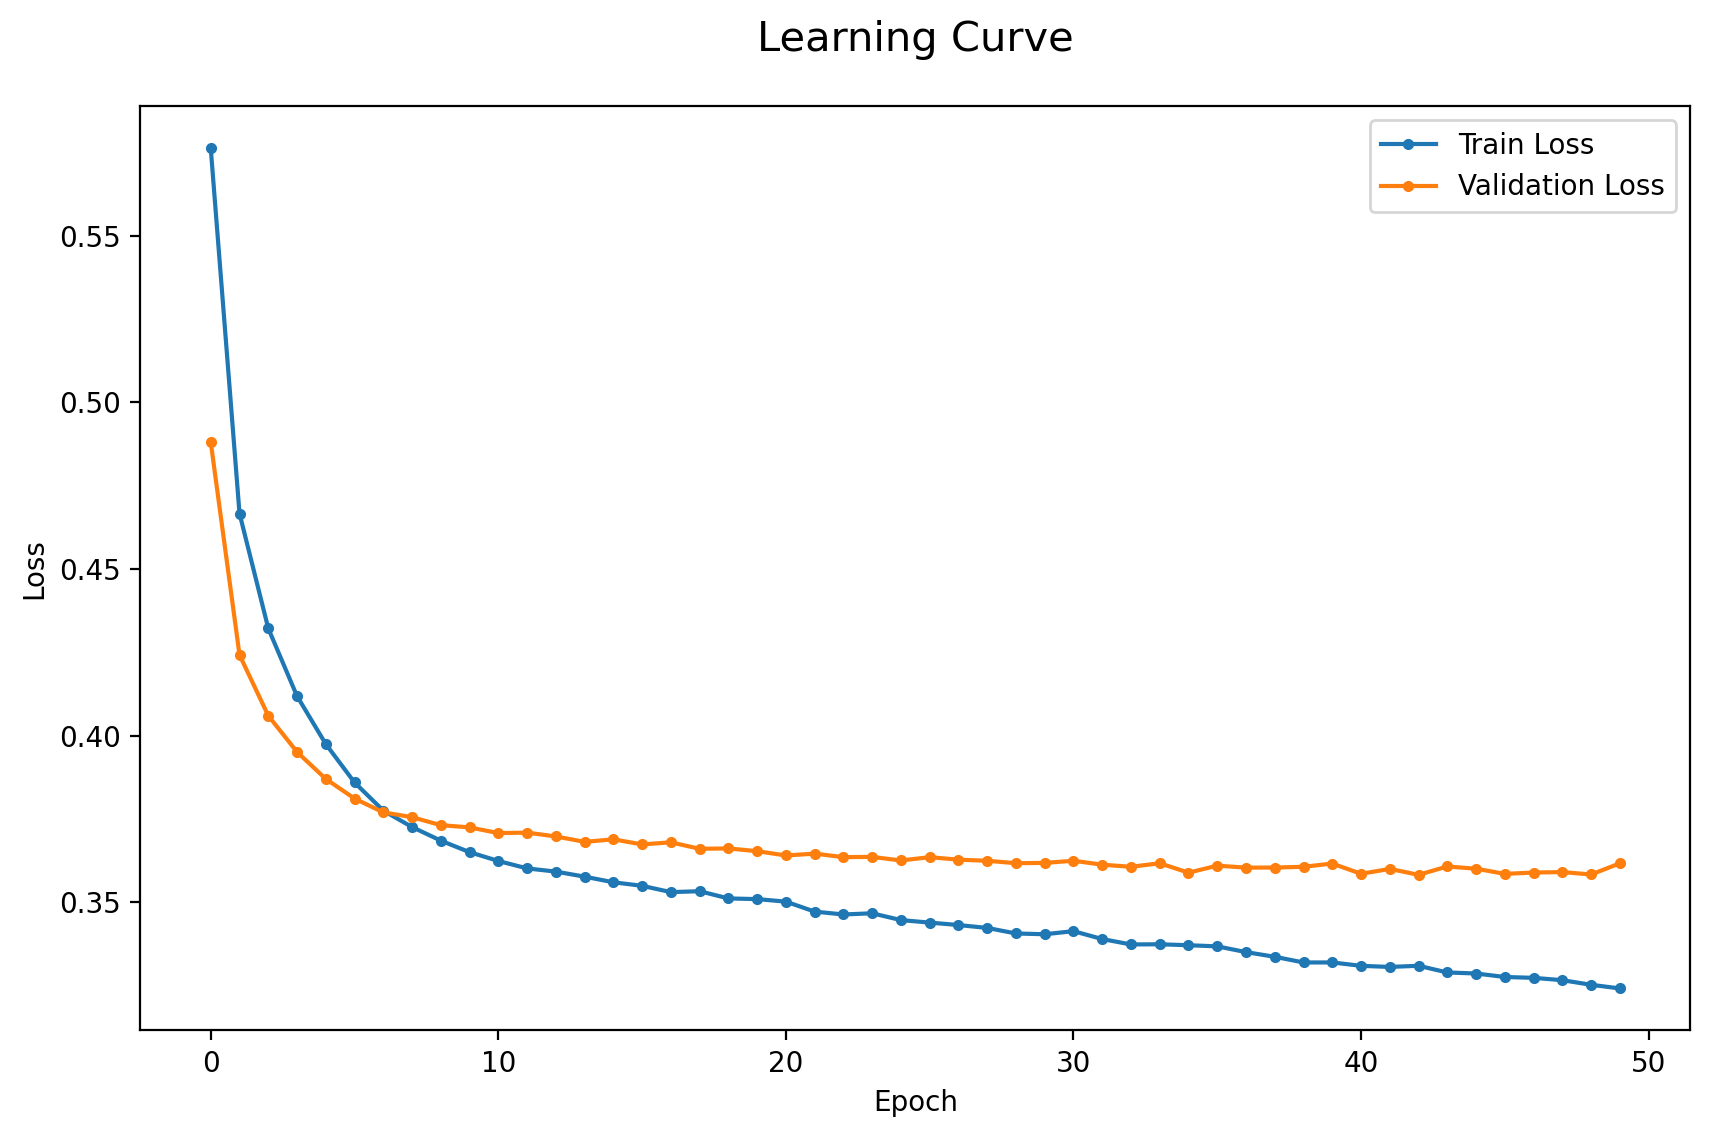

In [15]:
dl_history_plot(hist1)

## **3. 모델링 2**

- 다양한 구조의 모델을 설계합니다.
- Hidden Layer, Node 수 조절

#### 1) 모델 선언

In [20]:
model2 = Sequential([
    Input(shape=(nf,)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

model2.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy')

model2.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_11 (Dense)                │ (None, 64)             │           704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,329 (13.00 KB)

 Trainable params: 3,329 (13.00 KB)

 Non-trainable params: 0 (0.00 B)

#### 2) 모델 학습

In [21]:
hist2 = model2.fit(x_train_scaled, y_train, epochs=50, validation_split=0.2).history

Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.6173 - val_loss: 0.5158
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4731 - val_loss: 0.4153
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4294 - val_loss: 0.3930
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4043 - val_loss: 0.3779
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3871 - val_loss: 0.3719
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3760 - val_loss: 0.3688
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3684 - val_loss: 0.3686
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3631 - val_loss: 0.3688
Epoch 9/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3601 - val_loss: 0.3673
Epoch 10/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3566 - val_loss: 0.3665
Epoch 11/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3544 - val_loss: 0.3665
Epoch 12/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3547 - val_

#### 3) 예측 및 모델 평가

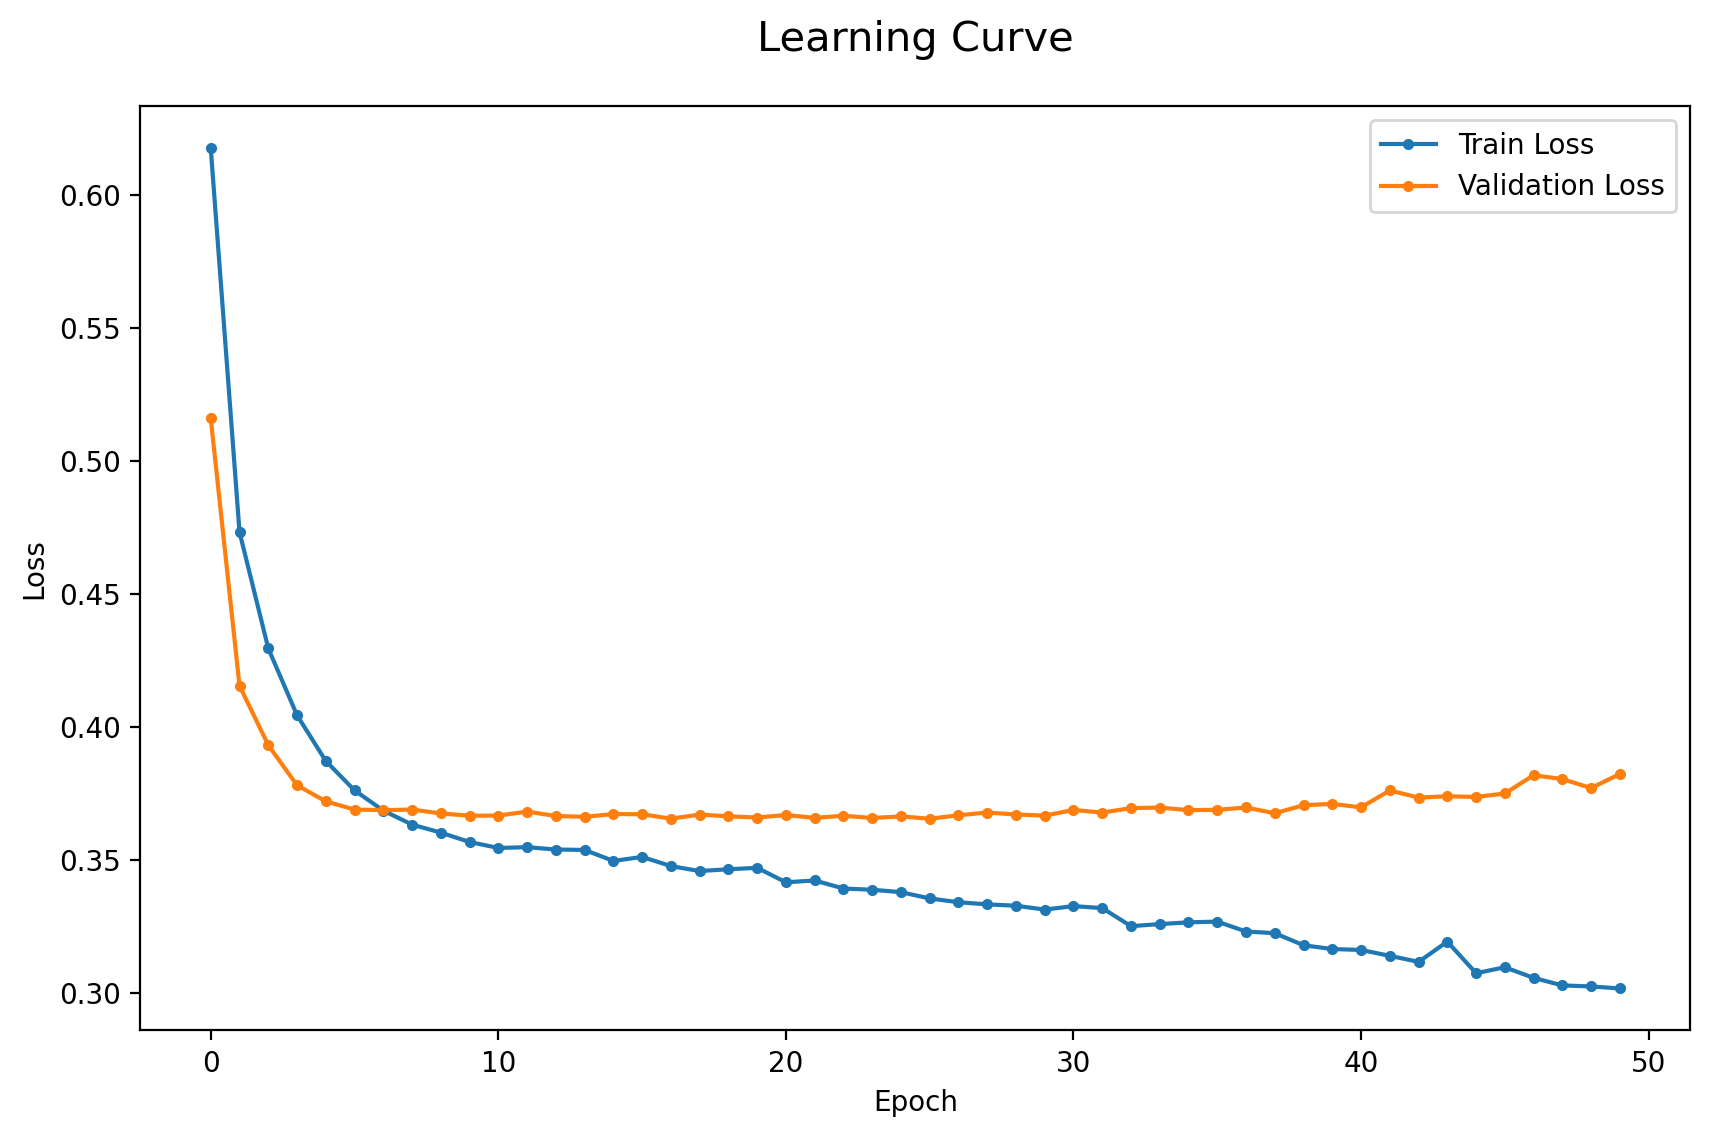

In [22]:
dl_history_plot(hist2)


In [29]:
y_pred2 = model2.predict(x_val_scaled)

y_pred2 = (y_pred2 > 0.5).astype(int)
y_pred2[:5]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


array([[0],
       [0],
       [0],
       [0],
       [0]])

In [31]:
print(classification_report(y_val, y_pred2))

              precision    recall  f1-score   support

           0       0.87      0.90      0.89       198
           1       0.44      0.36      0.39        42

    accuracy                           0.81       240
   macro avg       0.66      0.63      0.64       240
weighted avg       0.79      0.81      0.80       240



## **4. 모델링 3: Resampling**

- 불균형 클래스이므로 언더 샘플링 후 모델링합니다.

#### 1) Resampling

In [10]:
# 함수 불러오기
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

In [11]:
# 언더 샘플링
rus = RandomUnderSampler()
x_train_rus, y_train_rus = rus.fit_resample(x_train_scaled, y_train)

In [12]:
x_train_scaled

,Age,DistanceFromHome,JobSatisfaction,MonthlyIncome,PercentSalaryHike,TotalWorkingYears,Gender_Male,MaritalStatus_Married,MaritalStatus_Single,OverTime_Yes
1176,0.095238,0.071429,1.000000,0.097391,0.000000,0.025,1,1,0,1
910,0.619048,0.964286,1.000000,0.650206,0.500000,0.575,0,1,0,1
801,0.476190,0.000000,1.000000,0.349424,0.142857,0.250,0,0,1,0
297,0.404762,0.250000,0.666667,0.175029,0.428571,0.150,1,0,1,0
167,0.404762,0.321429,0.000000,0.491021,0.428571,0.375,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...
409,0.380952,0.142857,1.000000,0.157230,0.214286,0.375,1,1,0,0
1142,0.571429,0.607143,0.000000,0.232439,0.428571,0.225,1,0,0,1
192,0.261905,0.678571,1.000000,0.148041,0.142857,0.275,1,1,0,0
541,0.714286,0.000000,0.666667,0.230907,0.142857,0.575,1,0,1,1


#### 2) 모델 선언

In [13]:
clear_session()

nf = x_train_rus.shape[1]

model3 = Sequential([
    Input(shape=(nf,)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

model3.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,329 (13.00 KB)

 Trainable params: 3,329 (13.00 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
model3.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy')

#### 3) 모델 학습

In [15]:
hist3 = model3.fit(x_train_rus, y_train_rus, epochs=100, validation_split=0.2).history

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 0.6819 - val_loss: 0.8255
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.6638 - val_loss: 0.8690
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.6519 - val_loss: 0.9268
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.6429 - val_loss: 0.9679
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.6337 - val_loss: 0.9541
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.6247 - val_loss: 0.9530
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.6156 - val_loss: 0.9616
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.6095 - val_loss: 0.9213
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.6019 - val_loss: 0.9538
Epoch 10/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.5949 - val_loss: 0.9193
Epoch 11/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.5892 - val_loss: 0.8978
Epoch 12/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.5826 - val_lo

#### 4) 예측 및 성능 평가

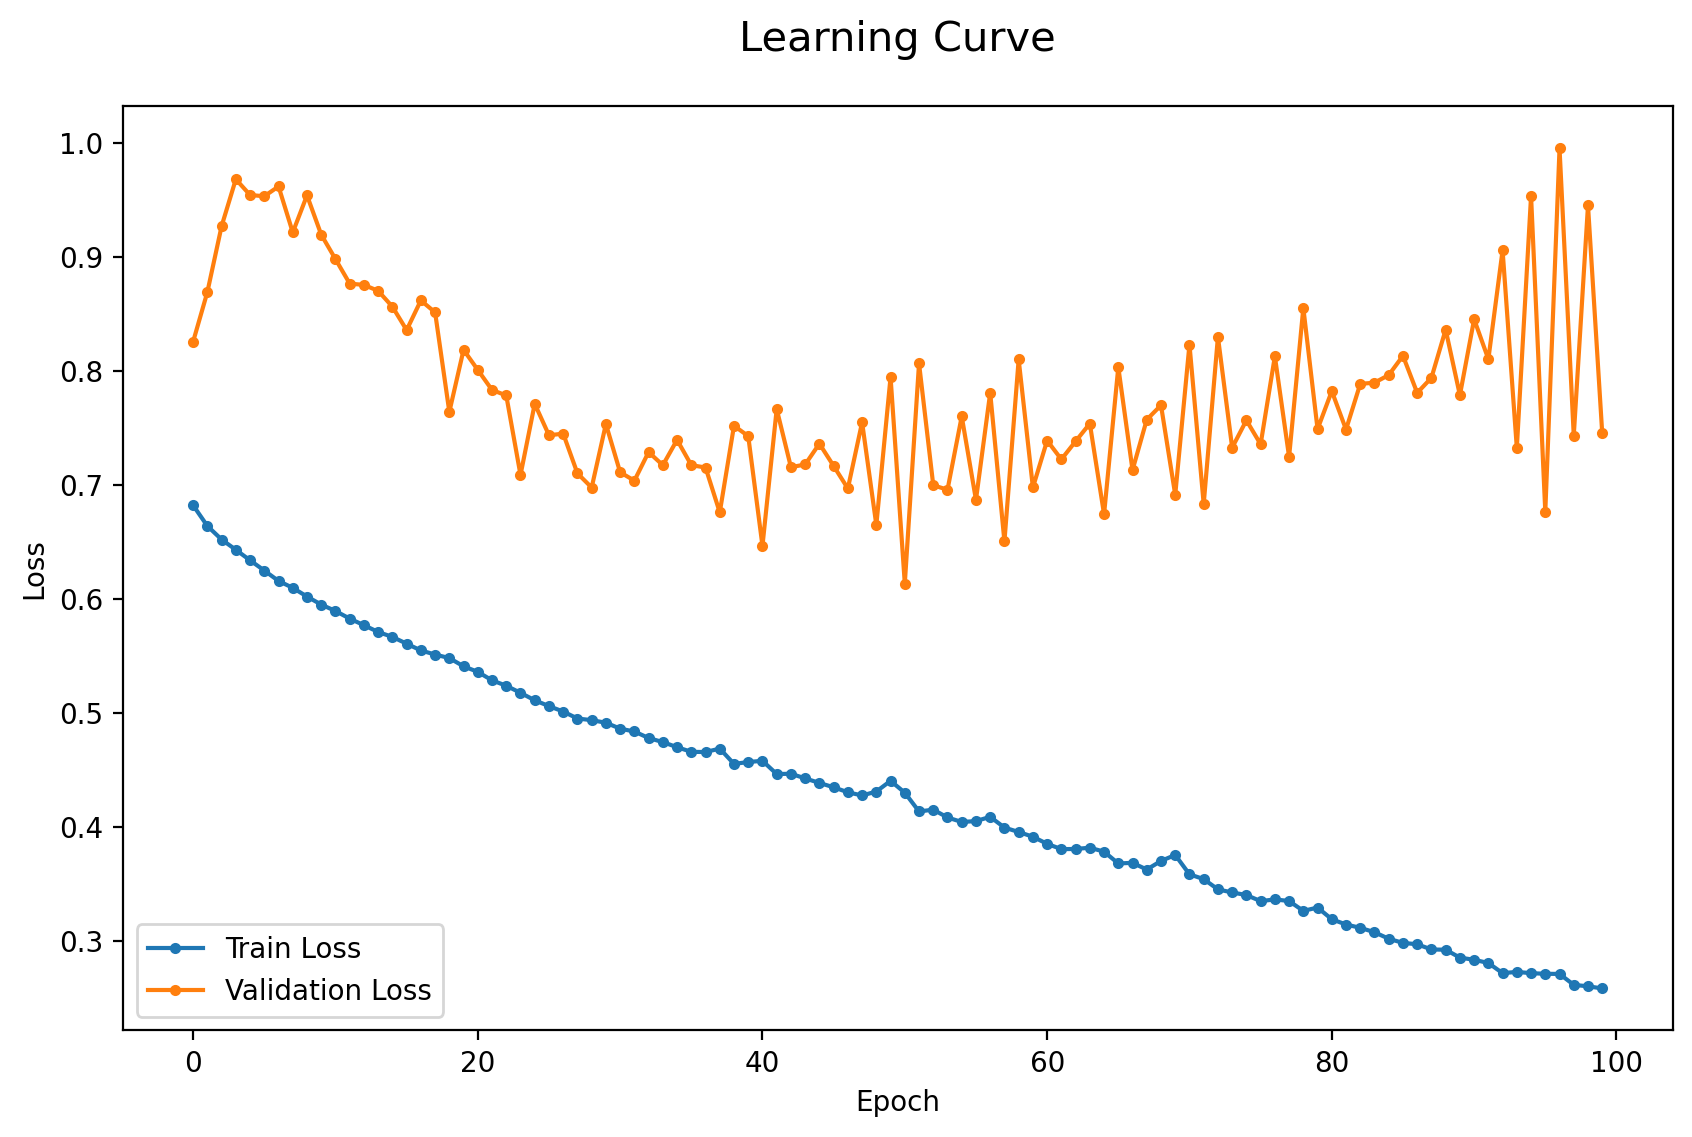

In [16]:
dl_history_plot(hist3)

In [23]:
y_pred3 = model3.predict(x_val_scaled)
y_pred3 = (y_pred3 > 0.1).astype(int)
print(np.sum(y_pred3 == 1))

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
157


In [24]:
print(classification_report(y_val, y_pred3))

              precision    recall  f1-score   support

           0       0.95      0.39      0.56       201
           1       0.22      0.90      0.36        39

    accuracy                           0.47       240
   macro avg       0.59      0.65      0.46       240
weighted avg       0.83      0.47      0.52       240

